In [44]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic

import os
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [105]:
# Model Opening
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'
lens_name = f'"{model_path}"'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result

['------------------------------------------\n',
 'optimize ndim=0\n',
 'run 1: 0 lens models calculated\n',
 'chi^2 = 1.000000e+30  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 1.000000e+30\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.080000e+01  2.075000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  5.000000e+00  5.000000e+01  0.000000e+00  3.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [106]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 1


['run 1: 0 lens models calculated\n',
 'chi^2 = 1.000000e+30  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 1.000000e+30\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.080000e+01  2.075000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  5.000000e+00  5.000000e+01  0.000000e+00  3.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [107]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'sie', '0.2613', '1.300000e+02', '2.080000e+01', '2.075000e+01', '1.070000e-01', '2.338000e+01', '0.000000e+00', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.090000e+01', '2.064000e+01', '5.000000e+00', '5.000000e+01', '0.000000e+00', '3.000000e+00']
Number of lens profiles: 2


{'sie': [130.0, 20.8, 20.75, 0.107, 23.38, 0.0, 0.0],
 'pert': [1.0, 20.9, 20.64, 5.0, 50.0, 0.0, 3.0]}

In [ ]:
# Initialize a dictionary to hold the lens parameters
set_point_dict = {}

# Extract the lens parameters
set_points = []
for line in opt_result:
    if line.startswith('point'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)

set_point_values = [float(x) for x in parts[1:]]

set_point_values

['point', '1.0000', '2.078000e+01', '2.078000e+01']


[1.0, 20.78, 20.78]

In [109]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)

df


,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,sie,130.0,20.8,20.75,0.107,23.38,0.0,0.0
1,pert,1.0,20.9,20.64,5.000,50.00,0.0,3.0


In [110]:
df['Lens Name'] = df['Lens Name'].apply(lambda x: f'"{x}"')

In [111]:
with open(model_path + '/' + 'pos_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'Test/SIE+SHEAR/SIE_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 1', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.80, 20.75, 0.107, 23.38, 0.000000e+00, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.90, 20.64, 5.0, 50.0, 0.0, 3.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_point(1, 0, 0, 0)\n',
 '\n',
 '# model_init needs to be done

In [112]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 0
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/sie"
Found glafic.set_lens
Found glafic.set_point


In [113]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/sie_lens.fits 



In [114]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: Test/SIE+SHEAR/sie_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [115]:
# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)
kappa

array([[0.14583714, 0.14687921, 0.14793123, ..., 0.1653072 , 0.16410884,
        0.16291921],
       [0.14669019, 0.14774983, 0.14881982, ..., 0.16634162, 0.16511944,
        0.16390653],
       [0.14754759, 0.14862508, 0.14971334, ..., 0.16737993, 0.16613352,
        0.16489695],
       ...,
       [0.15467492, 0.15574661, 0.15682575, ..., 0.1484443 , 0.14742781,
        0.14641961],
       [0.15378754, 0.15483965, 0.1558988 , ..., 0.14751221, 0.1465137 ,
        0.14552309],
       [0.15290323, 0.1539361 , 0.15497556, ..., 0.1465869 , 0.145606  ,
        0.14463267]], dtype='>f4')

Text(0, 0.5, 'Y Pixel')

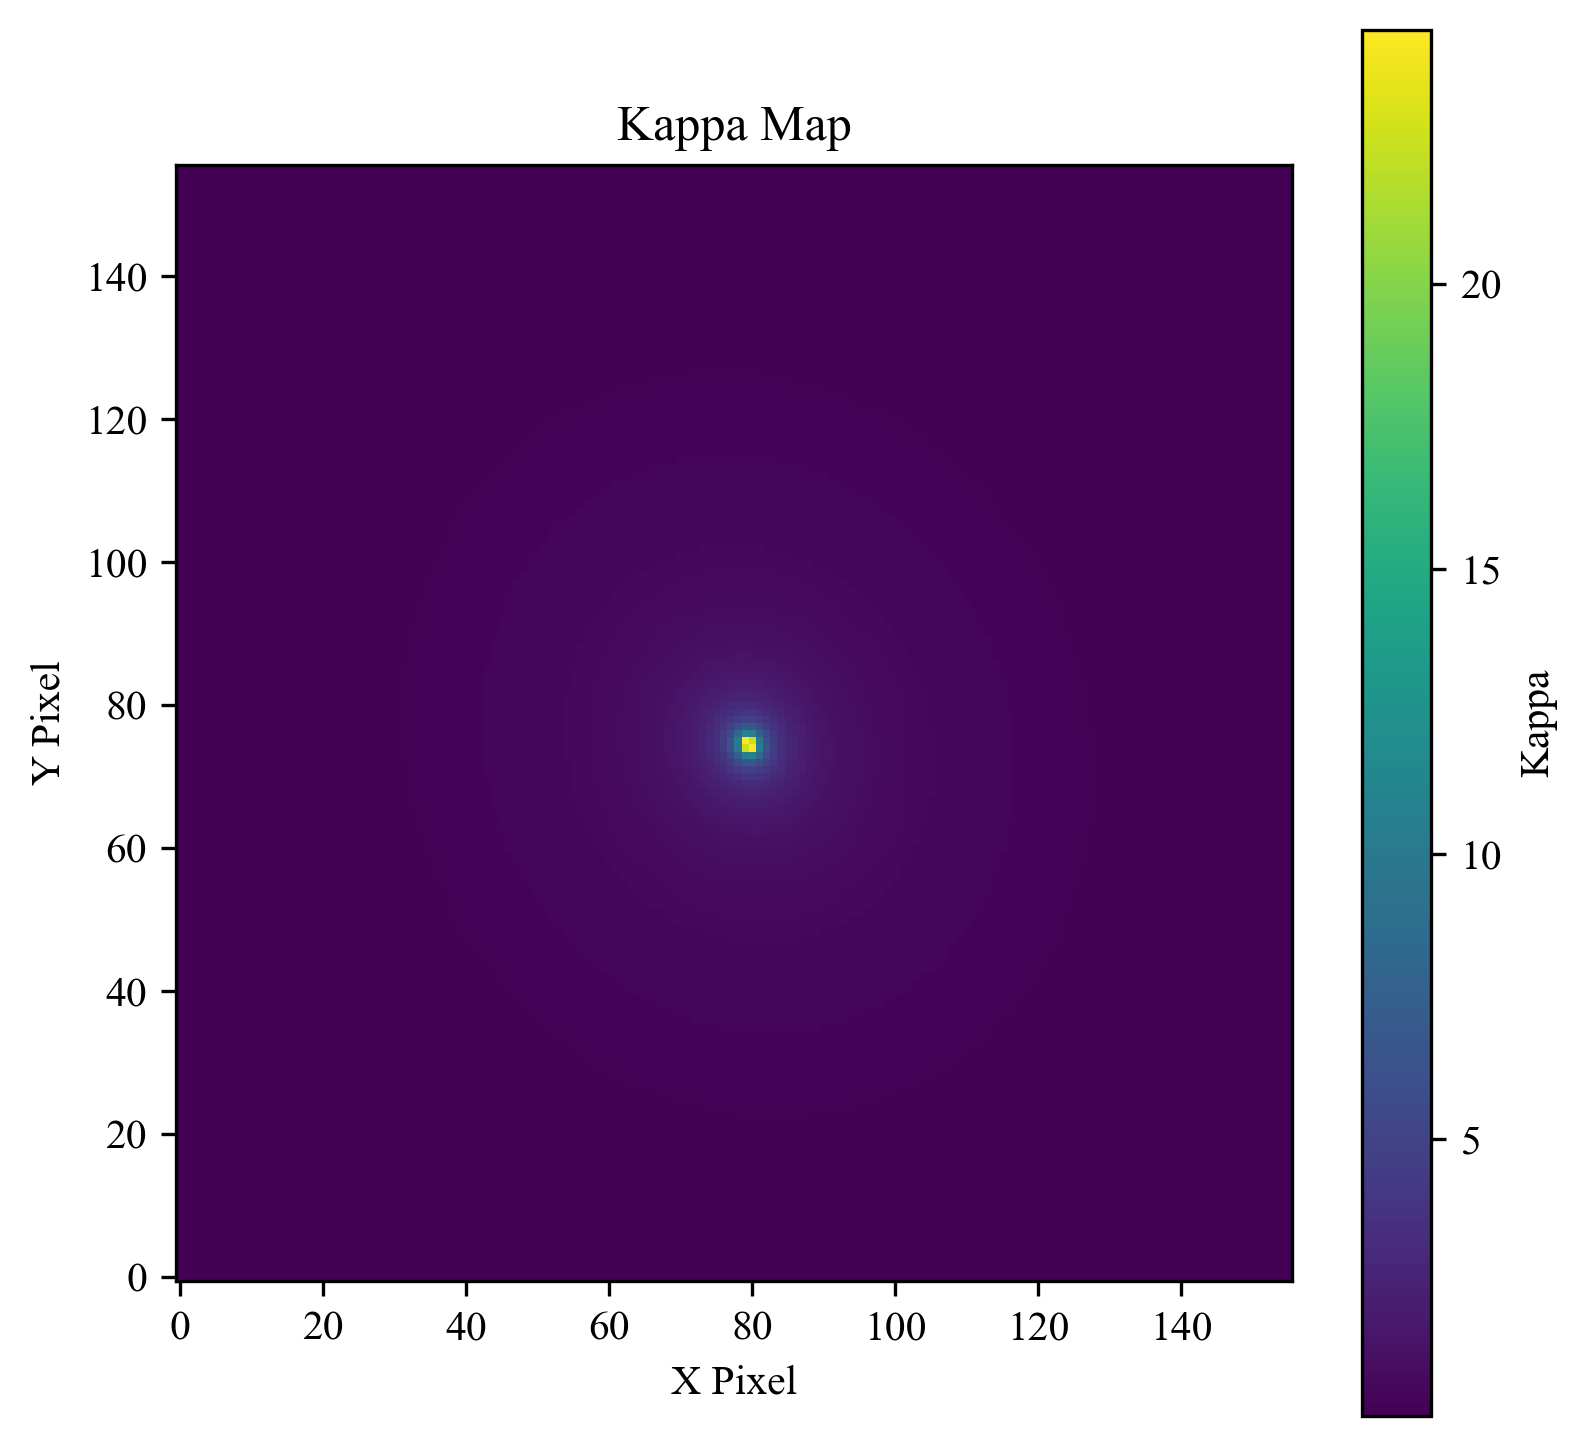

In [116]:
plt.figure(figsize=(6, 6))
# vmin, vmax = np.percentile(kappa, [1, 99])
# plt.imshow(kappa, cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.imshow(kappa, cmap='viridis', origin='lower')
plt.colorbar(label='Kappa')
plt.title('Kappa Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')


In [136]:
# From profile center
centers = [df['param2'][i], df['param3'][i]]
centers

[20.8, 20.75]

Center coordinates: (80.00000000000007, 75.0)

--- Calculating Azimuthally Averaged Profile ---


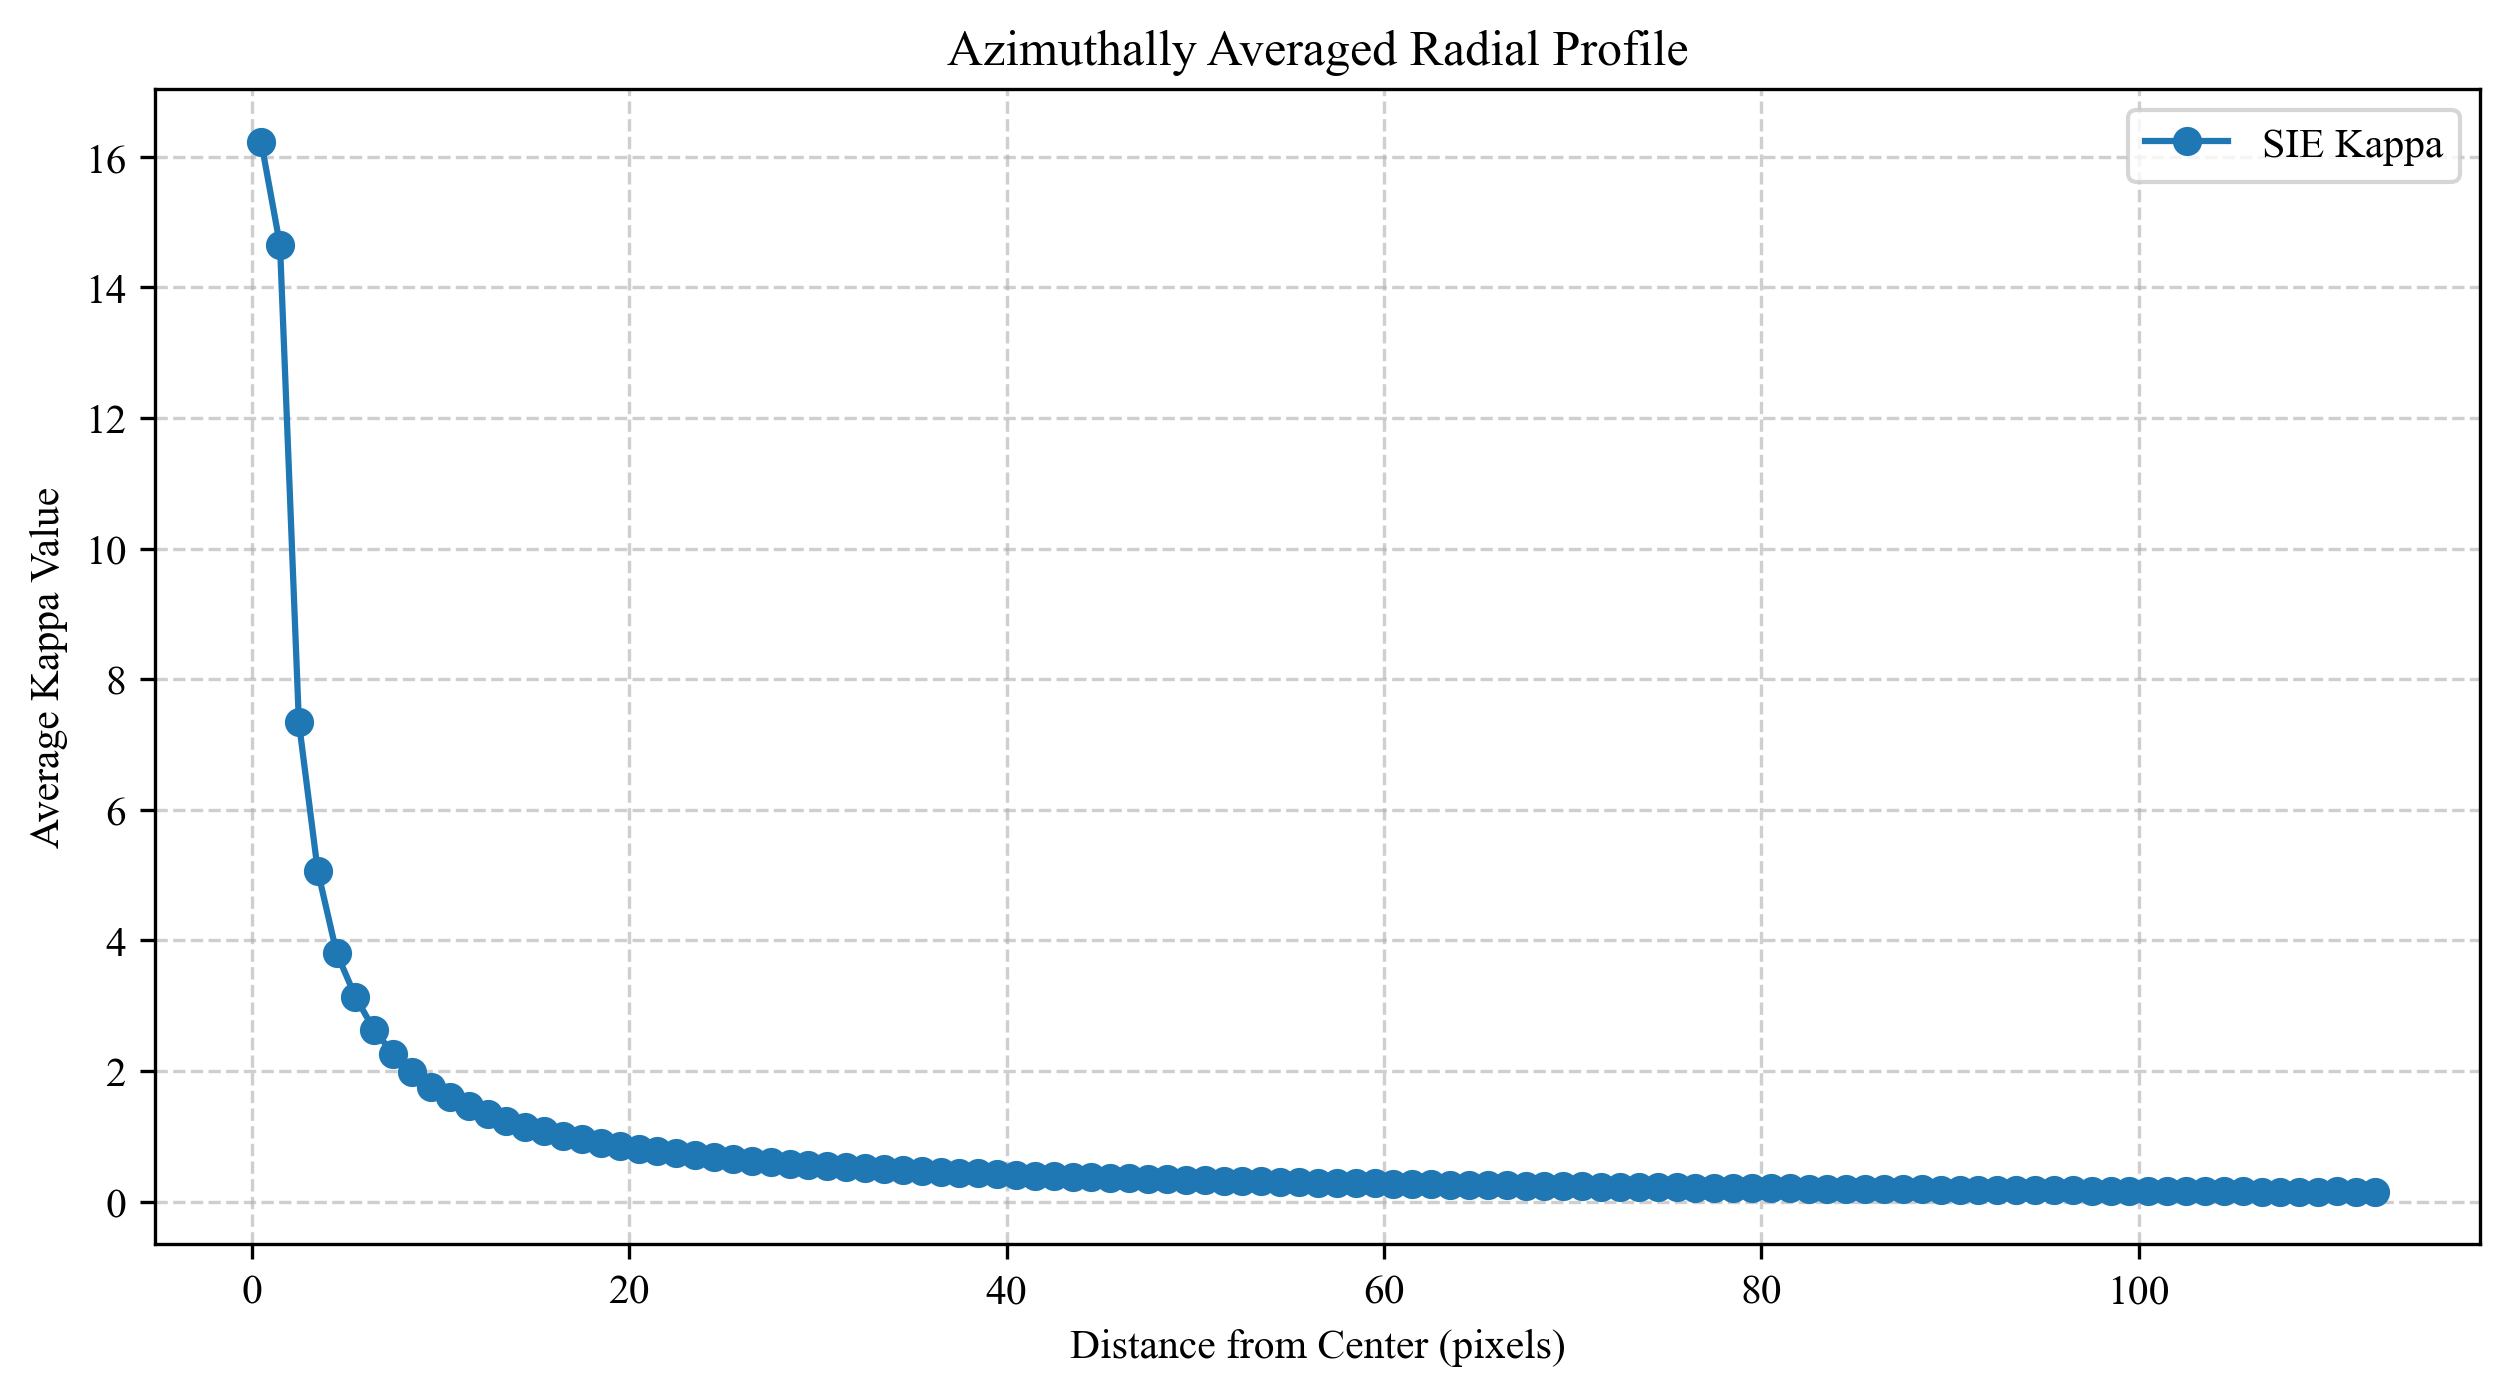

In [144]:
# Unpack the center coordinates
center_x, center_y = centers
center_x = (center_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (center_y - 20) / 0.01  # Convert to pixel coordinates
print(f"Center coordinates: ({center_x}, {center_y})")

#======================================================================
# Method 1: Azimuthally Averaged Radial Profile (Most Common)
#======================================================================
print("\n--- Calculating Azimuthally Averaged Profile ---")

# 1. Create a grid of integer coordinates
ny, nx = kappa.shape
y, x = np.indices((ny, nx))

# 2. Create a grid of distances from the center
#    This is a 2D array where each element is the distance of that
#    pixel from (center_x, center_y).
r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

# 3. Flatten the arrays to 1D
r_flat = r.flatten()
kappa_flat = kappa.flatten()

# 4. Bin the data by radius
#    Create radial bins of 1 pixel width.
radial_bins = np.arange(0, r.max(), 1)

#    Use binned_statistic to calculate the mean kappa value in each radial bin.
#    This is more efficient than looping through each bin manually.
radial_profile, bin_edges, _ = binned_statistic(
    r_flat, 
    kappa_flat, 
    statistic='mean', 
    bins=radial_bins
)

# The x-values for our plot should be the center of each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 5. Plot the result
plt.figure(figsize=(10, 5))
plt.title('Azimuthally Averaged Radial Profile')
plt.plot(bin_centers, radial_profile, 'o-', label='SIE Kappa')
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Average Kappa Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


--- Calculating Line Profile at a Specific Angle ---
Center coordinates: (20.8, 20.75)


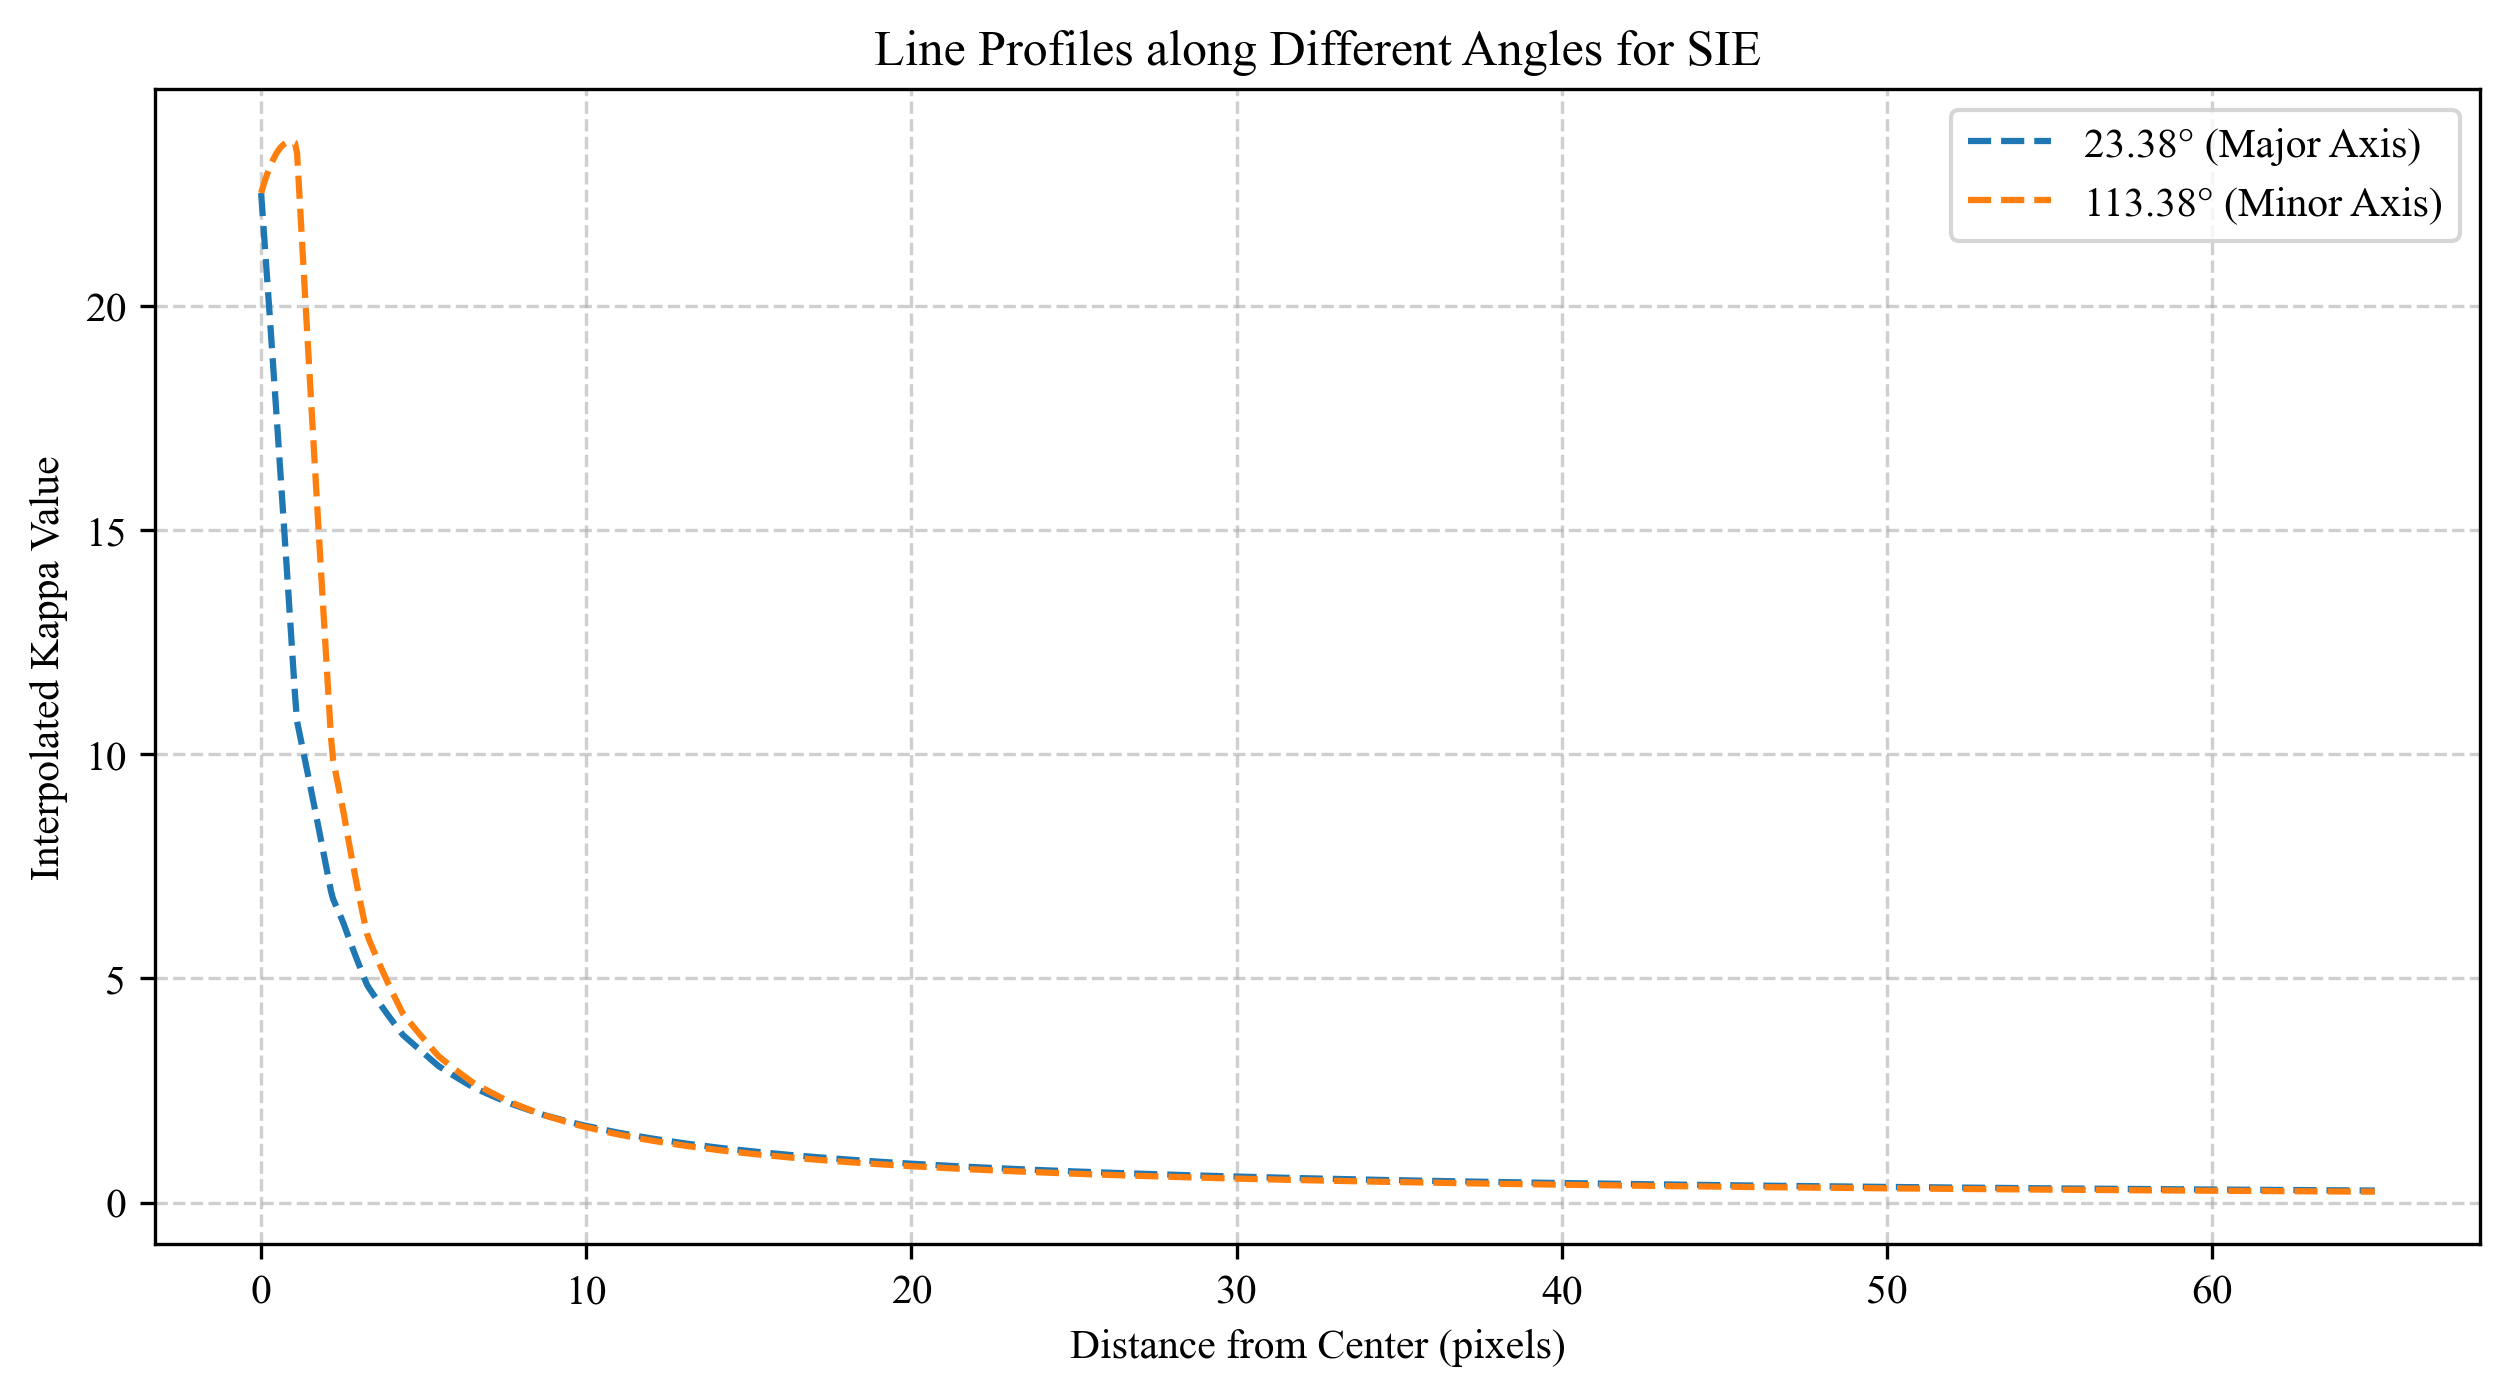

In [155]:
#======================================================================
# Method 2: Line Profile at a Specific Angle
#======================================================================
print("\n--- Calculating Line Profile at a Specific Angle ---")

major_axis = df['param5'][0]
minor_axis = df['param5'][0] + 90

angles_deg = [major_axis, minor_axis]
angle_names = ['Major Axis', 'Minor Axis']
max_radius = 65
num_points = 1000

center_x, center_y = centers
print(f"Center coordinates: ({center_x}, {center_y})")
center_x = (center_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (center_y - 20) / 0.01  # Convert to pixel coordinates


plt.figure(figsize=(10, 5))
for angle_deg_0 in angles_deg:
    angle_deg = angle_deg_0 + 90
    angle_rad = np.deg2rad(angle_deg)
    radii = np.linspace(0, max_radius, num=num_points)
    x_coords = center_x + radii * np.cos(angle_rad)
    y_coords = center_y + radii * np.sin(angle_rad)
    coords = np.vstack((y_coords, x_coords))
    line_profile = map_coordinates(kappa, coords, order=1)
    plt.plot(radii, line_profile, '--', label=f'{angle_deg_0}° ({angle_names[angles_deg.index(angle_deg_0)]})')
plt.title('Line Profiles along Different Angles for SIE')
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Interpolated Kappa Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [119]:
lens_name = model_path
lens_name = lens_name + '/' + model_ver + '_macro'
lens_name = f'"{lens_name}"'
print(lens_name)

# Read original file
with open('Test/kappa_common.py', 'r') as f:
    py = f.readlines()

# Modify lines
new_lines = []
for line in py:
    if 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_lens(1' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][0]}, 0.261343256161012, {df['param1'][0]}, {df['param2'][0]}, {df['param3'][0]}, {df['param4'][0]}, {df['param5'][0]}, {df['param6'][0]}, {df['param7'][0]})\n"
    elif 'glafic.set_lens(2' in line:
        line = f"glafic.set_lens(2, {df['Lens Name'][1]}, 0.261343256161012, {df['param1'][1]}, {df['param2'][1]}, {df['param3'][1]}, {df['param4'][1]}, {df['param5'][1]}, {df['param6'][1]}, {df['param7'][1]})\n"
    elif 'glafic.set_lens(3' in line:
        line = f"glafic.set_lens(3, {df['Lens Name'][2]}, 0.261343256161012, {df['param1'][2]}, {df['param2'][2]}, {df['param3'][2]}, {df['param4'][2]}, {df['param5'][2]}, {df['param6'][2]}, {df['param7'][2]})\n"
    elif 'glafic.set_lens(4' in line:
        line = f"glafic.set_lens(4, {df['Lens Name'][3]}, 0.261343256161012, {df['param1'][3]}, {df['param2'][3]}, {df['param3'][3]}, {df['param4'][3]}, {df['param5'][3]}, {df['param6'][3]}, {df['param7'][3]})\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write once, after all edits
with open('Test/kappa_common.py', 'w') as f:
    f.writelines(new_lines)

"Test/SIE+SHEAR/SIE_POS_SHEAR_macro"
Found glafic.set_lens
Found glafic.set_point


In [120]:
%run Test/kappa_common.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits 



In [121]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [122]:
# Extract kappa 
kappa_macro = hdu_list[0].data[3]
kappa_macro = np.array(kappa_macro)
kappa_macro

gamma1 = hdu_list[0].data[4]
gamma1 = np.array(gamma1)
gamma2 = hdu_list[0].data[5]
gamma2 = np.array(gamma2)

Text(0, 0.5, 'Y Pixel')

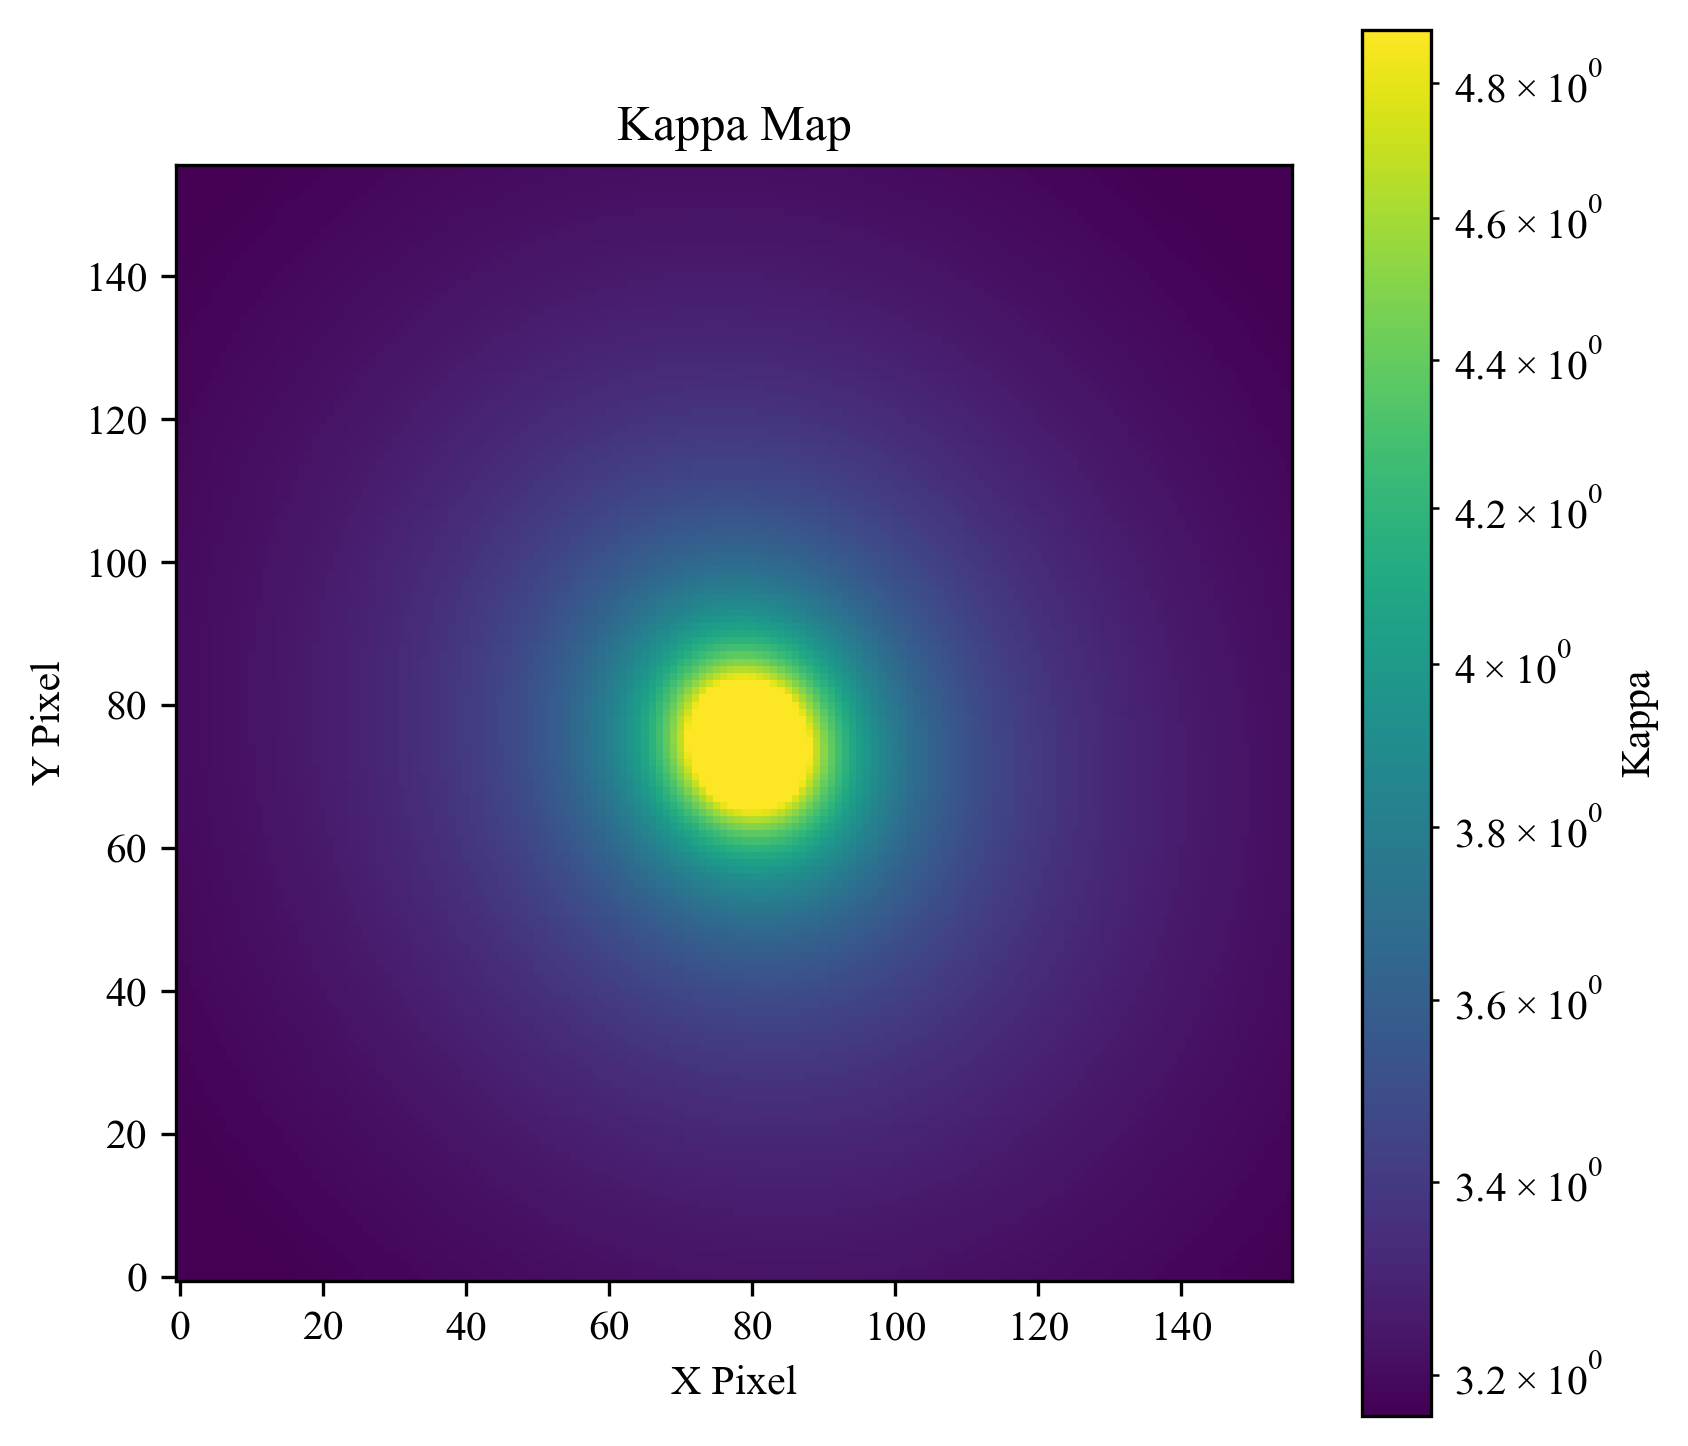

In [158]:
plt.figure(figsize=(6, 6))
vmin, vmax = np.percentile(kappa_macro, [1, 99])
plt.imshow(kappa_macro, cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(label='Kappa')
plt.title('Kappa Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')


Center coordinates: (20.8, 20.75)

--- Calculating Azimuthally Averaged Profile ---


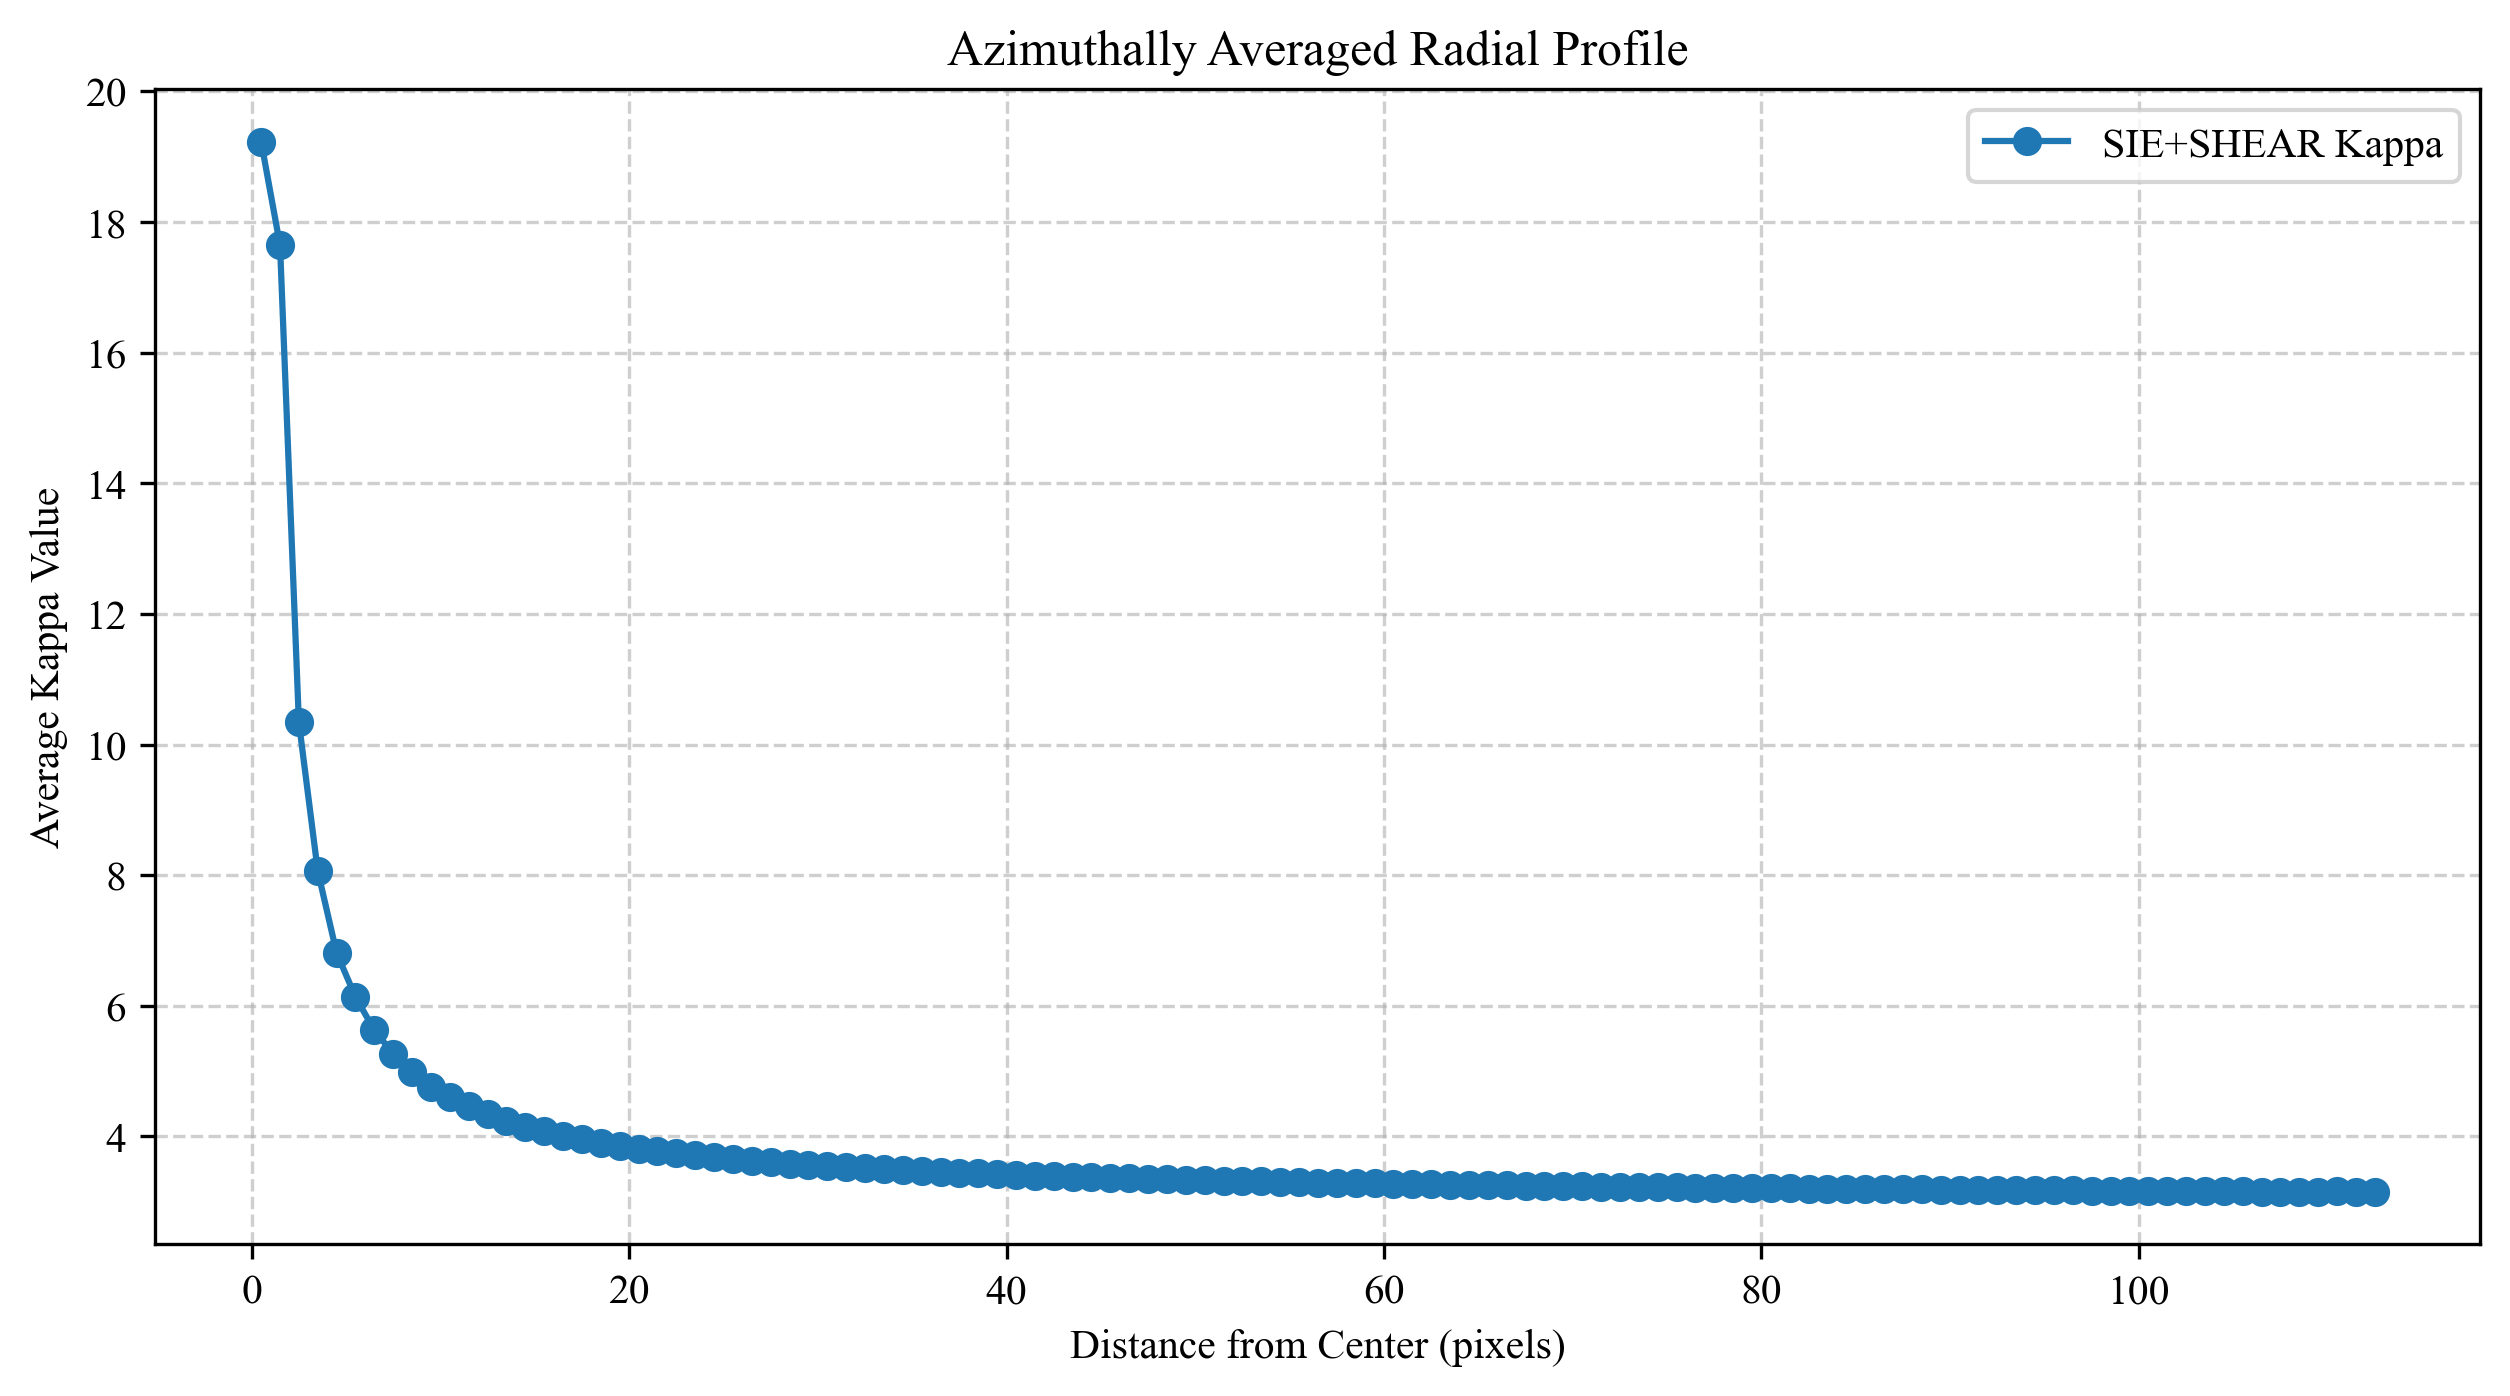

In [141]:
# Unpack the center coordinates
center_x, center_y = centers
print(f"Center coordinates: ({center_x}, {center_y})")
center_x = (center_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (center_y - 20) / 0.01  # Convert to pixel coordinates

#======================================================================
# Method 1: Azimuthally Averaged Radial Profile (Most Common)
#======================================================================
print("\n--- Calculating Azimuthally Averaged Profile ---")

# 1. Create a grid of integer coordinates
ny, nx = kappa_macro.shape
y, x = np.indices((ny, nx))

# 2. Create a grid of distances from the center
#    This is a 2D array where each element is the distance of that
#    pixel from (center_x, center_y).
r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

# 3. Flatten the arrays to 1D
r_flat = r.flatten()
kappa_flat = kappa_macro.flatten()

# 4. Bin the data by radius
#    Create radial bins of 1 pixel width.
radial_bins = np.arange(0, r.max(), 1)

#    Use binned_statistic to calculate the mean kappa value in each radial bin.
#    This is more efficient than looping through each bin manually.
radial_profile, bin_edges, _ = binned_statistic(
    r_flat, 
    kappa_flat, 
    statistic='mean', 
    bins=radial_bins
)

# The x-values for our plot should be the center of each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 5. Plot the result
plt.figure(figsize=(10, 5))
plt.title('Azimuthally Averaged Radial Profile')
plt.plot(bin_centers, radial_profile, 'o-', label='SIE+SHEAR Kappa')
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Average Kappa Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


--- Calculating Line Profile at a Specific Angle ---
Center coordinates: (20.8, 20.75)


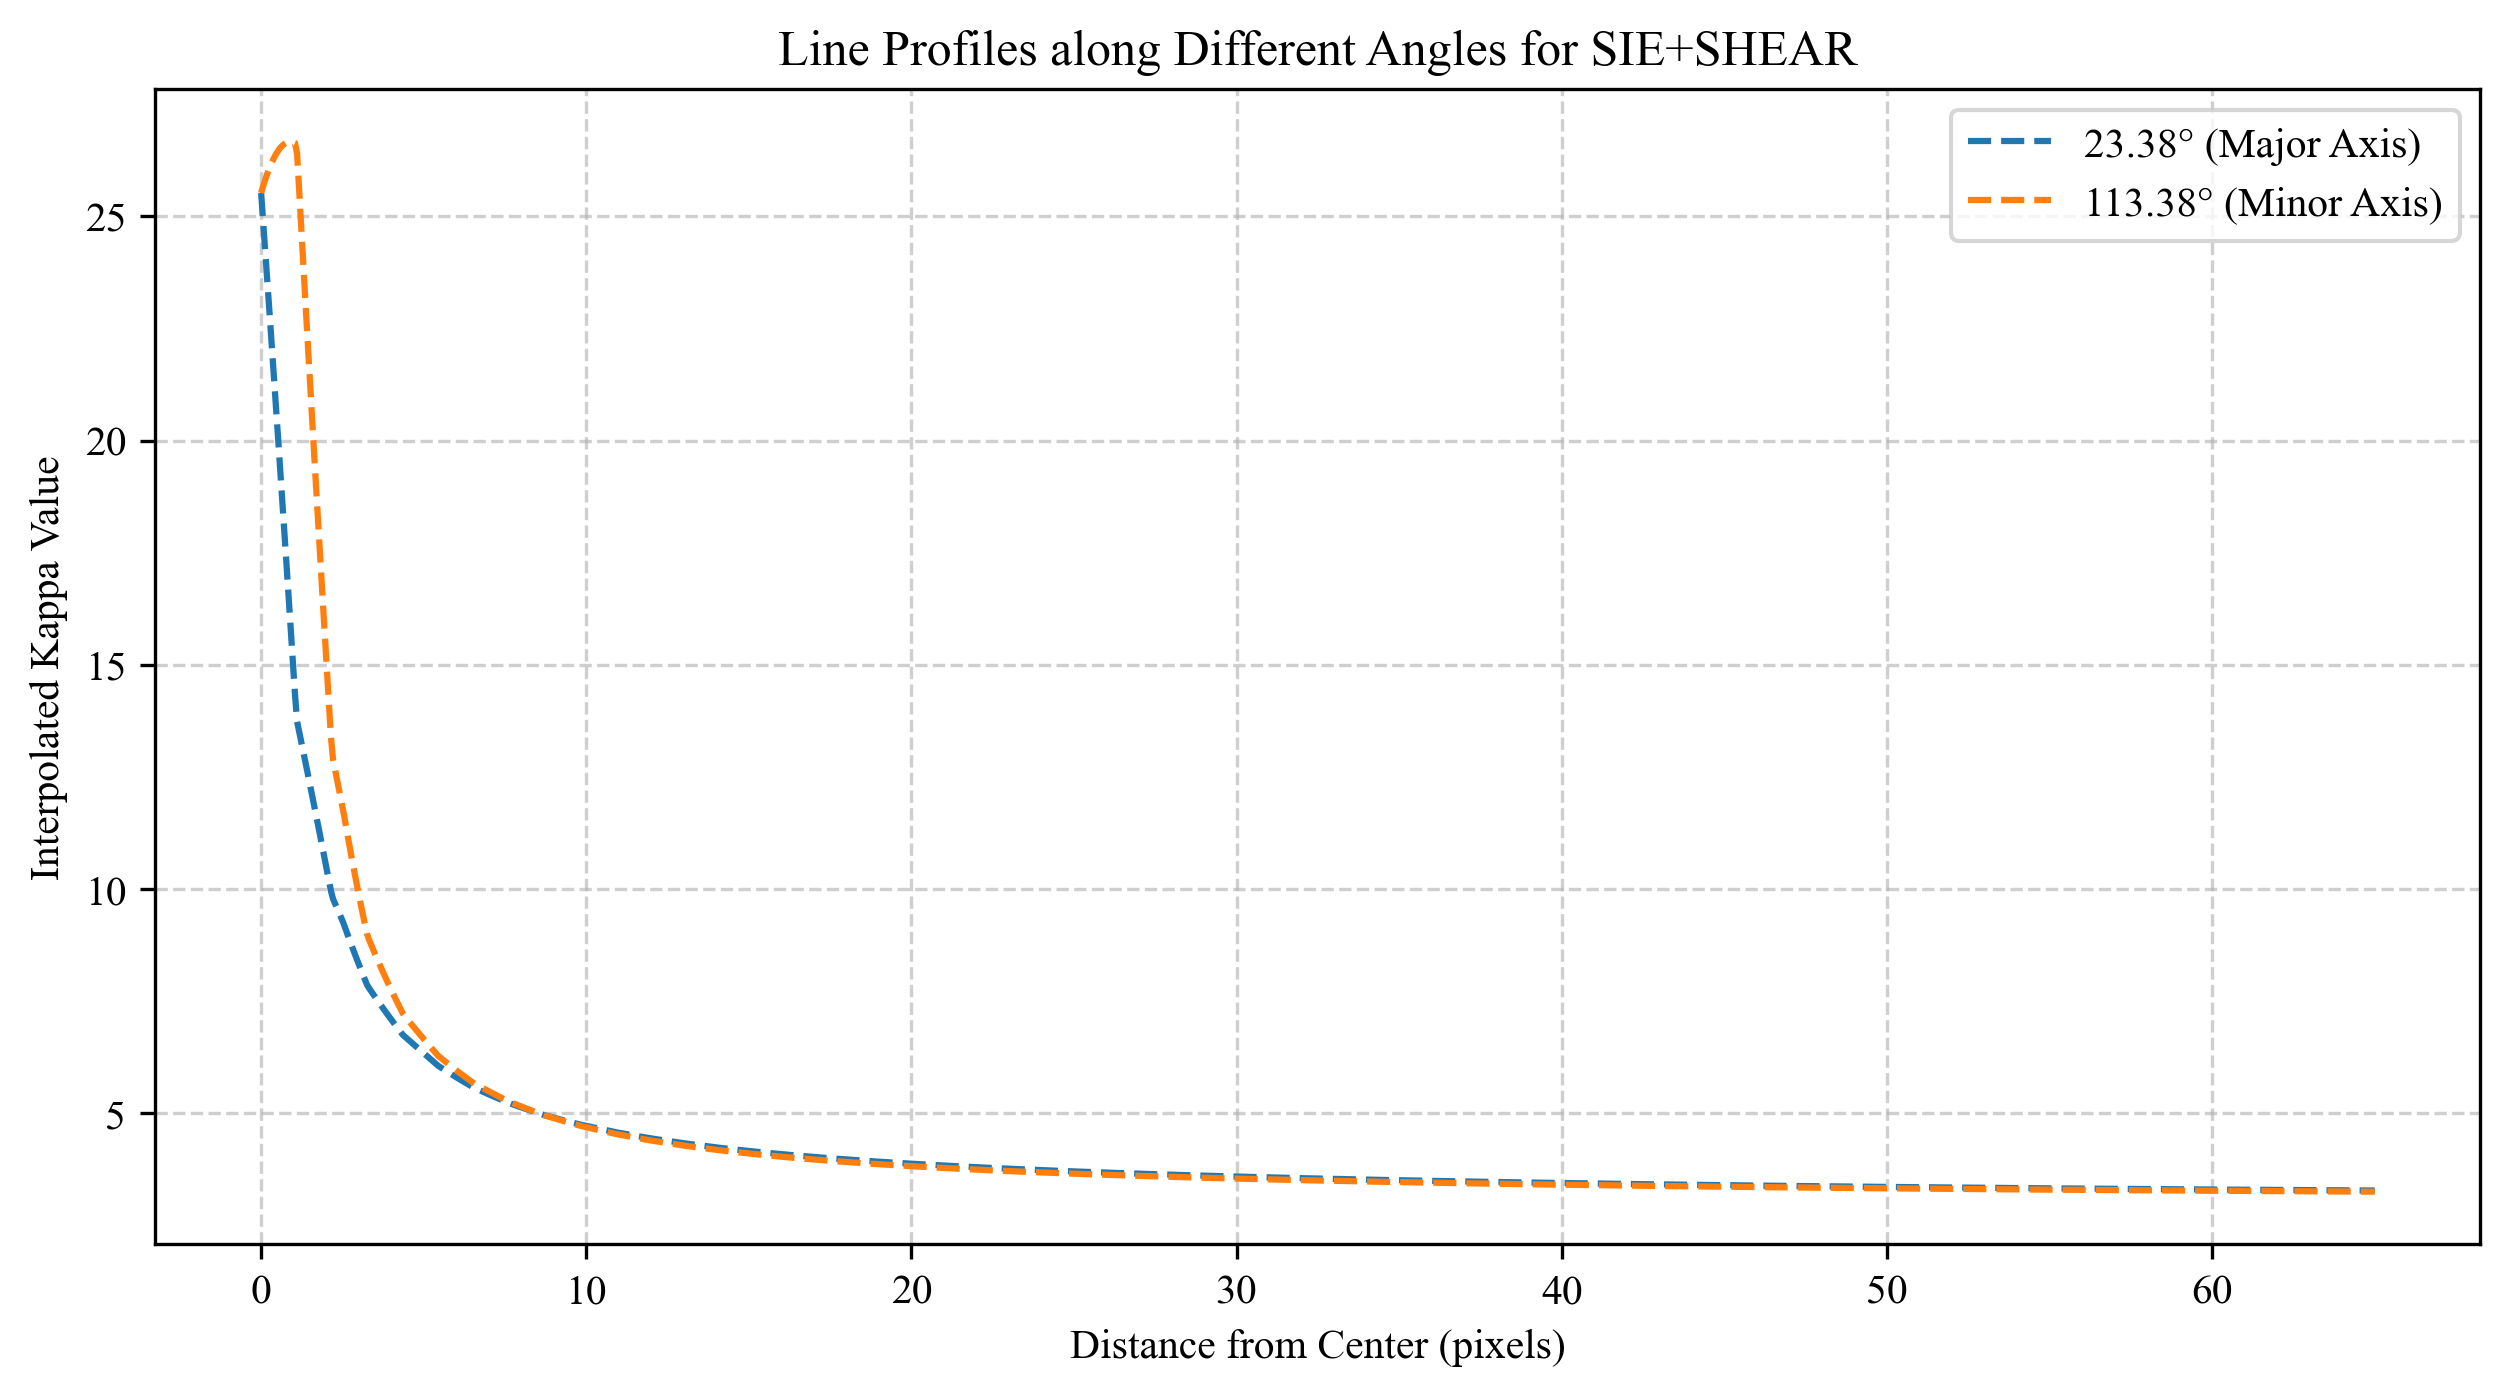

In [156]:
#======================================================================
# Method 2: Line Profile at a Specific Angle
#======================================================================
print("\n--- Calculating Line Profile at a Specific Angle ---")

major_axis = df['param5'][0]
minor_axis = df['param5'][0] + 90

angles_deg = [major_axis, minor_axis]
angle_names = ['Major Axis', 'Minor Axis']
max_radius = 65
num_points = 1000

center_x, center_y = centers
print(f"Center coordinates: ({center_x}, {center_y})")
center_x = (center_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (center_y - 20) / 0.01  # Convert to pixel coordinates


plt.figure(figsize=(10, 5))
for angle_deg_0 in angles_deg:
    angle_deg = angle_deg_0 + 90
    angle_rad = np.deg2rad(angle_deg)
    radii = np.linspace(0, max_radius, num=num_points)
    x_coords = center_x + radii * np.cos(angle_rad)
    y_coords = center_y + radii * np.sin(angle_rad)
    coords = np.vstack((y_coords, x_coords))
    line_profile = map_coordinates(kappa_macro, coords, order=1)
    plt.plot(radii, line_profile, '--', label=f'{angle_deg_0}° ({angle_names[angles_deg.index(angle_deg_0)]})')
plt.title('Line Profiles along Different Angles for SIE+SHEAR')
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Interpolated Kappa Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


Using profile center (x, y) in pixel coordinates: (80.00, 75.00)


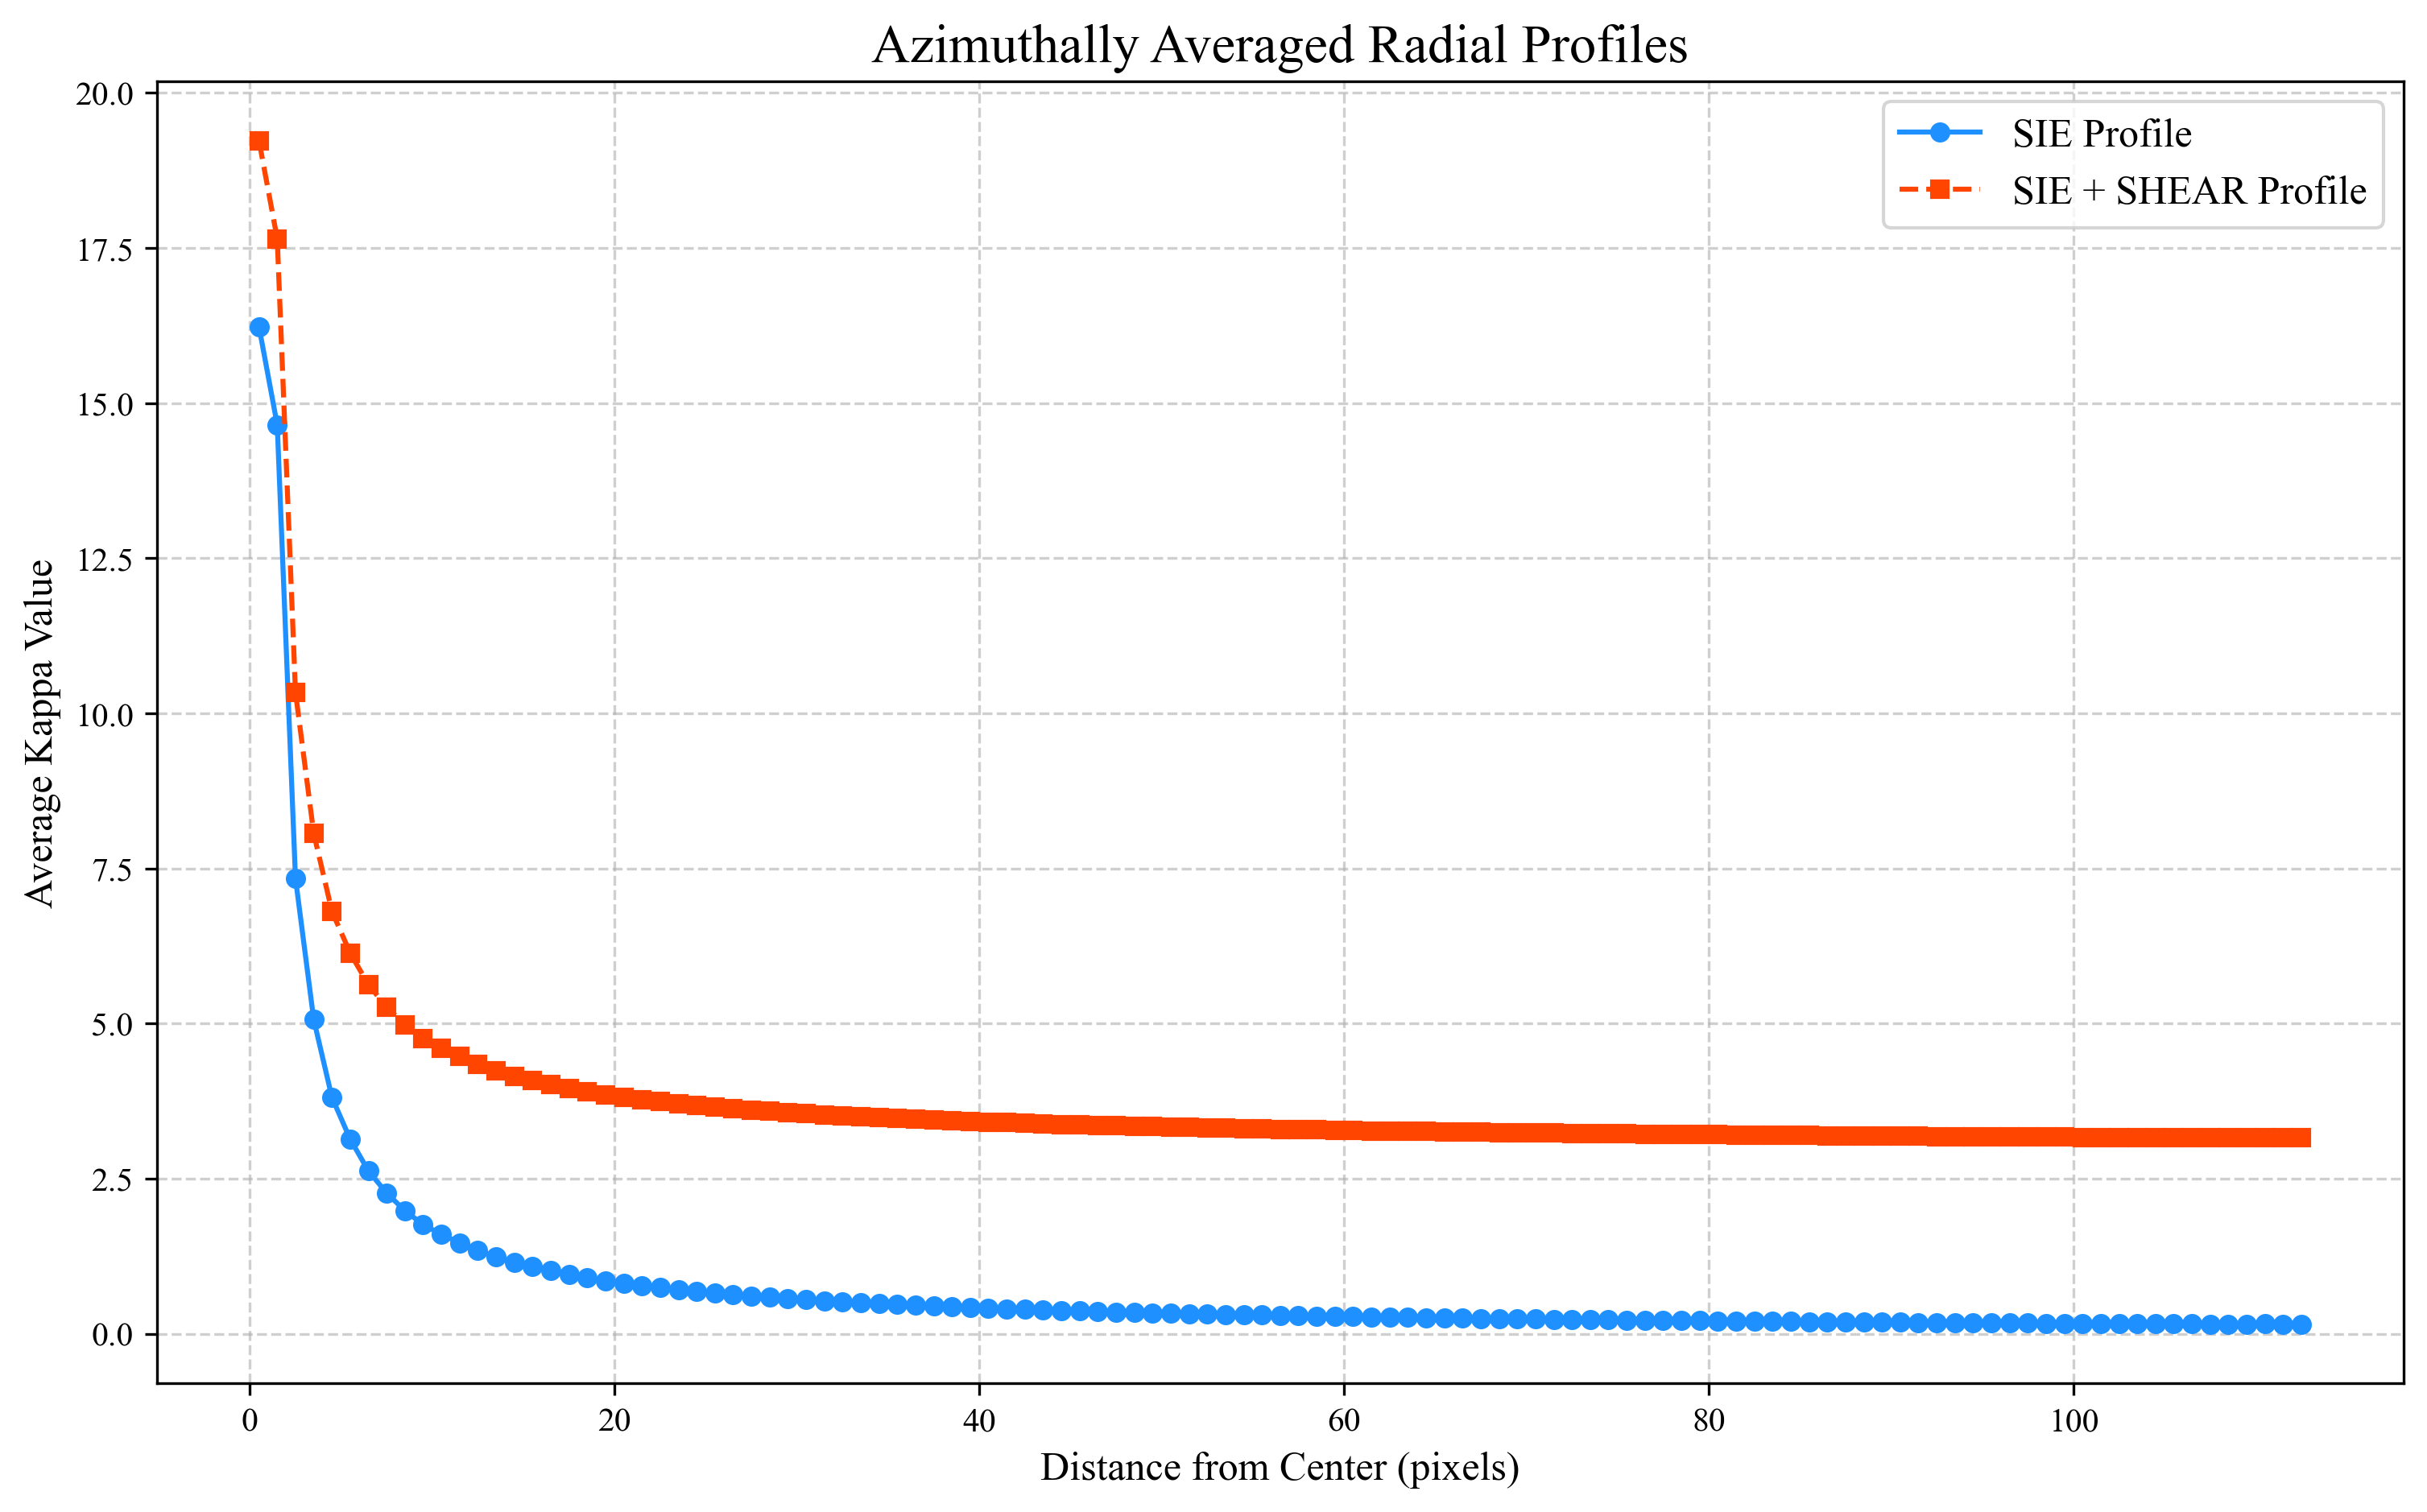

In [140]:
def calculate_radial_profile(image_data, center_coords):
    """
    Calculates the azimuthally averaged radial profile of an image.

    Args:
        image_data (np.ndarray): The 2D image array.
        center_coords (tuple): A tuple containing the (x, y) pixel coordinates of the center.

    Returns:
        tuple: A tuple containing (bin_centers, radial_profile).
    """
    center_x, center_y = center_coords
    
    # Create a grid of integer coordinates
    ny, nx = image_data.shape
    y, x = np.indices((ny, nx))

    # Create a grid of distances from the center
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    # Flatten the arrays to 1D for binning
    r_flat = r.flatten()
    image_flat = image_data.flatten()

    # Bin the data by radius using a 1-pixel width
    radial_bins = np.arange(0, r.max(), 1)

    # Use binned_statistic to calculate the mean value in each radial bin
    profile, bin_edges, _ = binned_statistic(
        r_flat, 
        image_flat, 
        statistic='mean', 
        bins=radial_bins
    )

    # Calculate the center of each bin for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, profile

# ======================================================================
# Main Script
# ======================================================================

# 1. Define and convert center coordinates ONCE
physical_x, physical_y = centers
center_x = (physical_x - 20) / 0.01  # Convert to pixel coordinates
center_y = (physical_y - 20) / 0.01  # Convert to pixel coordinates
print(f"Using profile center (x, y) in pixel coordinates: ({center_x:.2f}, {center_y:.2f})")

# 2. Calculate the profile for each dataset using our function
bin_centers_kappa, profile_kappa = calculate_radial_profile(kappa, (center_x, center_y))
bin_centers_macro, profile_macro = calculate_radial_profile(kappa_macro, (center_x, center_y))

# 3. Plot both profiles on the same figure
plt.figure(figsize=(12, 7))
plt.title('Azimuthally Averaged Radial Profiles', fontsize=16)

# Plot the first profile
plt.plot(bin_centers_kappa, profile_kappa, 'o-', color='dodgerblue', label='SIE Profile', markersize=5)

# Plot the second profile on the SAME axes
plt.plot(bin_centers_macro, profile_macro, 's--', color='orangered', markersize=5, label='SIE + SHEAR Profile')

# Add labels and other plot elements
plt.xlabel('Distance from Center (pixels)', fontsize=12)
plt.ylabel('Average Kappa Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

Using profile center (x, y) in pixel coordinates: (80.00, 75.00)


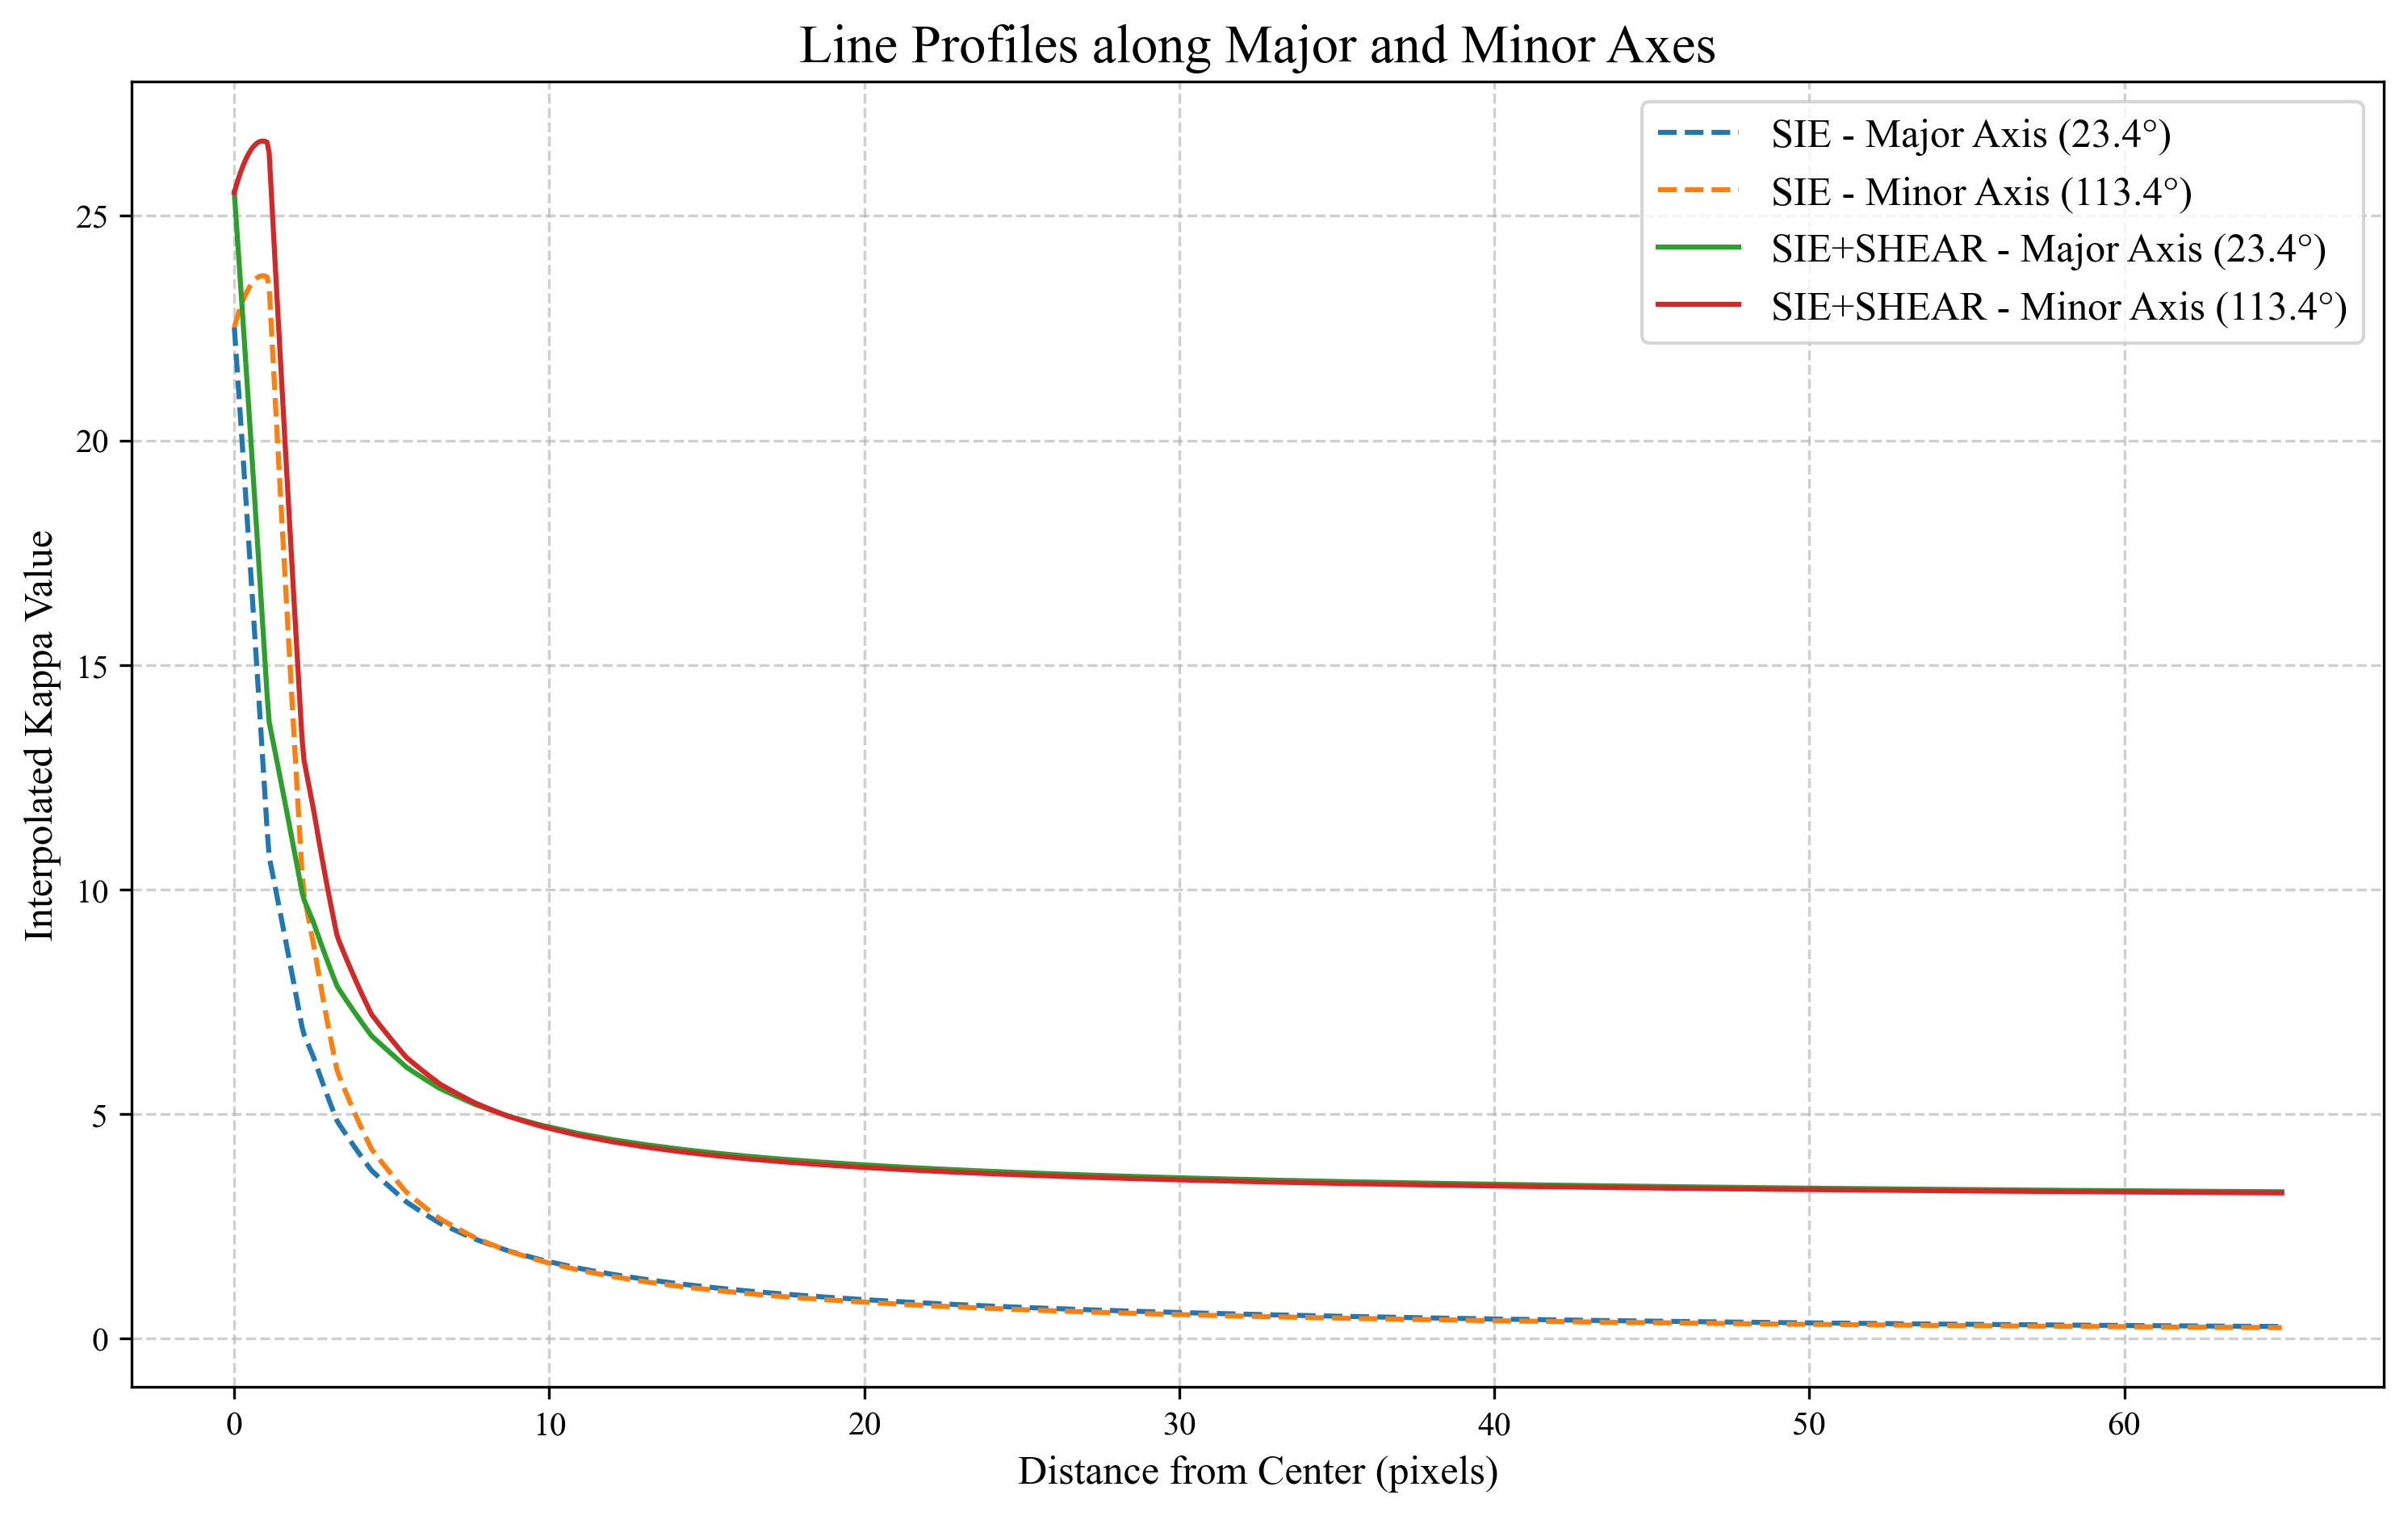

In [157]:
def calculate_line_profile(image_data, center_px, angle_deg, max_radius, num_points):
    """
    Calculates a 1D line profile from an image at a specific angle.

    Args:
        image_data (np.ndarray): The 2D image array.
        center_px (tuple): (x, y) pixel coordinates for the profile's center.
        angle_deg (float): The angle of the line profile in degrees.
        max_radius (float): The length of the profile from the center.
        num_points (int): The number of points to sample along the line.

    Returns:
        tuple: (radii, line_profile)
    """
    center_x, center_y = center_px
    angle_rad = np.deg2rad(angle_deg)
    
    # Generate the coordinates for the line
    radii = np.linspace(0, max_radius, num=num_points)
    x_coords = center_x + radii * np.cos(angle_rad)
    y_coords = center_y + radii * np.sin(angle_rad)

    # Interpolate the image values at these coordinates
    coords = np.vstack((y_coords, x_coords))
    line_profile = map_coordinates(image_data, coords, order=1)
    
    return radii, line_profile

# ======================================================================
# Main Script
# ======================================================================

# 1. Define common parameters
max_radius = 65
num_points = 1000

# 2. Define angles from your dataframe
# NOTE: The user's original code adds 90 degrees to these values.
# We will preserve this logic inside the loop.
major_axis_angle_0 = df['param5'][0]
minor_axis_angle_0 = major_axis_angle_0 + 90
angles_deg_0 = [major_axis_angle_0, minor_axis_angle_0]
angle_names = ['Major Axis', 'Minor Axis']

# 3. Define center and convert to pixel coordinates ONCE
phys_x, phys_y = centers
center_x = (phys_x - 20) / 0.01
center_y = (phys_y - 20) / 0.01
center_px = (center_x, center_y)
print(f"Using profile center (x, y) in pixel coordinates: ({center_px[0]:.2f}, {center_px[1]:.2f})")

# 4. Prepare the datasets and plot styles
# This structure makes it easy to add more datasets in the future
datasets = [
    {'name': 'SIE', 'data': kappa, 'linestyle': 'dashed'},
    {'name': 'SIE+SHEAR', 'data': kappa_macro, 'linestyle': 'solid'}
]

# 5. Create the plot and loop through datasets and angles
plt.figure(figsize=(12, 7))
plt.title('Line Profiles along Major and Minor Axes', fontsize=16)

# Loop over the two datasets (kappa and kappa_macro)
for dataset in datasets:
    # Then loop over the two angles (major and minor)
    for angle_0, axis_name in zip(angles_deg_0, angle_names):
        # Your original code added 90 degrees, so we do that here
        final_angle = angle_0 + 90
        
        # Calculate the profile using our new function
        radii, profile = calculate_line_profile(
            image_data=dataset['data'],
            center_px=center_px,
            angle_deg=final_angle,
            max_radius=max_radius,
            num_points=num_points
        )
        
        # Create a clear label for the legend
        label = f"{dataset['name']} - {axis_name} ({angle_0:.1f}°)"
        
        # Plot the result with the correct linestyle
        plt.plot(radii, profile, linestyle=dataset['linestyle'], label=label)

# 6. Finalize and show the plot
plt.xlabel('Distance from Center (pixels)', fontsize=12)
plt.ylabel('Interpolated Kappa Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()